In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import json


config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
existing_studies = vis2D.existing_studies_df()
# For each study, fit a line to Preferred period (deg) as a function of Eccentricity
fit_df = vis2D.fit_study_lines(existing_studies)
merged_df = pd.merge(existing_studies, fit_df, on='Paper')


In [5]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures')
lr = 0.0005
max_epoch = 30000
roi_list = ['V1']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in  [3,2,0]]
roi_pal.insert(0, (0.3,0.3,0.3))
stim_classes=['annulus', 'pinwheel', 'forward spiral','reverse spiral']
goal='replication'

pt_file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1']):
    file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', 'nsdsyn', 
                             f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision',f'precision-s_dset-nsdsyn_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
pt_file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = os.path.join(output_dir,'sfp_model', 'results_2D', 'broderick', f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
broderick_params = model.load_all_models(pt_file_list, *ARGS_2D)

broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'broderick', 'precision', f'precision-s_dset-broderick_vs-pRFsize.csv'))
broderick_df = pd.merge(broderick_params, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_params = pd.concat((broderick_df, nsd_df), axis=0)

In [7]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(nsd_subj_list, ['V1'], ['scaled']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', 'nsdsyn', 
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
nsd_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

nsd_df = pd.merge(nsd_prediction, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(broderick_subj_list, ['V1'], ['scaled']):
    file_name = os.path.join(output_dir,  'sfp_model', 'prediction_2D', 'broderick', 
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
broderick_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

broderick_df = pd.merge(broderick_prediction, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_df = pd.concat((broderick_df, nsd_df), axis=0)

In [8]:
final_df.query('eccentricity == 4.3')

,names,w_r,w_a,eccentricity,angle,sfstimuli,local_ori,Pv,sub,lr_rate,max_epoch,vroinames,precision,dset_type
172,pinwheel,0.0,-6.0,4.3,0.000000,scaled,1.570796,0.675995,wlsubj001,0.0005,30000,V1,10.369273,Broderick et al. V1
173,forward spiral,4.0,-4.0,4.3,0.000000,scaled,2.356194,0.720836,wlsubj001,0.0005,30000,V1,10.369273,Broderick et al. V1
174,annulus,6.0,-0.0,4.3,0.000000,scaled,0.000000,0.702274,wlsubj001,0.0005,30000,V1,10.369273,Broderick et al. V1
175,reverse spiral,4.0,4.0,4.3,0.000000,scaled,0.785398,0.720836,wlsubj001,0.0005,30000,V1,10.369273,Broderick et al. V1
656,pinwheel,0.0,-6.0,4.3,0.017453,scaled,1.588250,0.676041,wlsubj001,0.0005,30000,V1,10.369273,Broderick et al. V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396999,reverse spiral,4.0,4.0,4.3,6.265732,scaled,0.767945,1.180585,subj08,0.0005,30000,V1,0.200196,NSD V1
1397480,pinwheel,0.0,-6.0,4.3,6.283185,scaled,1.570796,0.881787,subj08,0.0005,30000,V1,0.200196,NSD V1
1397481,forward spiral,4.0,-4.0,4.3,6.283185,scaled,2.356194,1.176358,subj08,0.0005,30000,V1,0.200196,NSD V1
1397482,annulus,6.0,-0.0,4.3,6.283185,scaled,0.000000,0.774481,subj08,0.0005,30000,V1,0.200196,NSD V1


In [9]:
ecc_list = [4.3, 10]
additional_ecc_df = final_df.query('sfstimuli == "scaled" & dset_type == "NSD V1" & eccentricity in @ecc_list')
additional_ecc_df = additional_ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()
additional_ecc_df['dset_type'] = 'nsdv1'


In [10]:
ecc_list=[0,10]
nsd_ecc_df = final_df.query('sfstimuli == "scaled" & dset_type == "NSD V1" & eccentricity in @ecc_list')
nsd_ecc_df = nsd_ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()

ecc_list=[0,10]
bd_ecc_df = final_df.query('sfstimuli == "scaled" & dset_type == "Broderick et al. V1" & eccentricity in @ecc_list')
bd_ecc_df = bd_ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()

ecc_df = pd.concat((nsd_ecc_df, bd_ecc_df), axis=0)


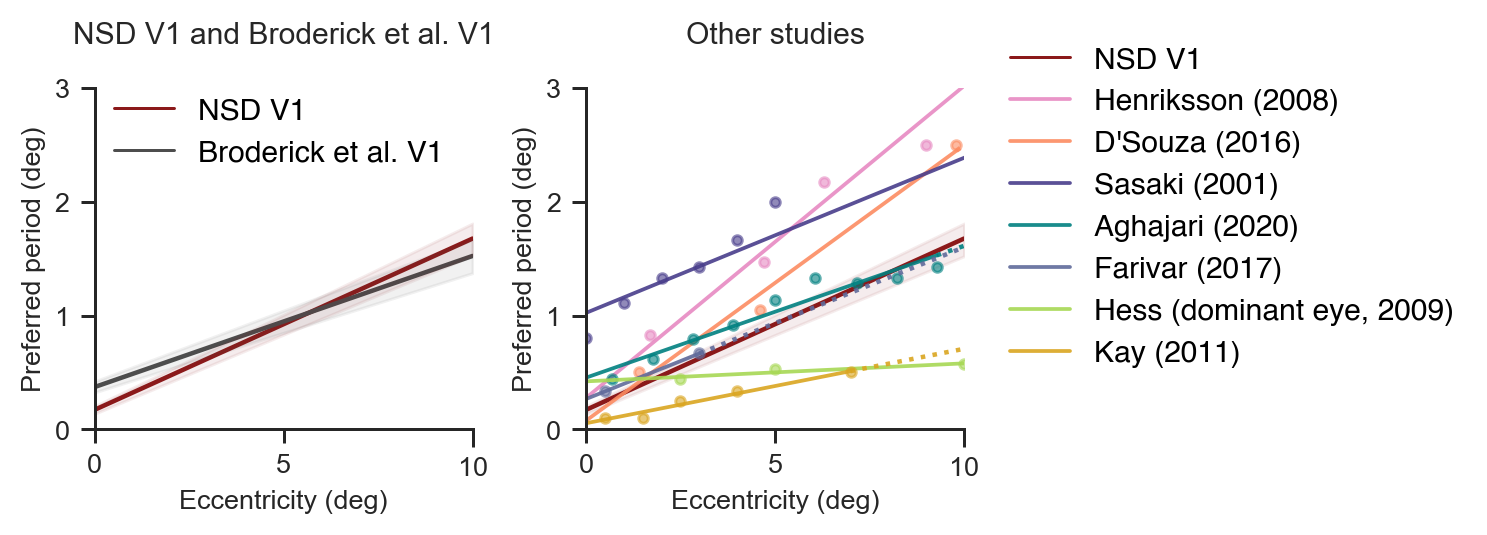

In [37]:
save_path=os.path.join(fig_dir, 'existing_studies', 'existing-studies.svg')
rc = {
      'axes.linewidth': 1,
      'axes.labelpad': 3,
      'xtick.major.pad': 5,
      'xtick.major.width': 1,
      'ytick.major.width': 1,
      'lines.linewidth': 1,
      'font.size': 9,
      'axes.titlesize': 9,
      'axes.labelsize': 9,
      'xtick.labelsize': 9,
      'ytick.labelsize': 9,
      'legend.title_fontsize': 9,
      'legend.fontsize': 9,
      'figure.titlesize': 9,
      'axes.spines.right': False,
      'axes.spines.top': False,
      }
sns.set_theme("paper", style='ticks', rc=rc, font_scale=0.1)
fig, axes = plt.subplots(1, 2, figsize=(7, 2.5))
#axes[0] = vis2D.plot_preferred_period_in_axes(additional_ecc_df, 'eccentricity', 'Pv', hue='dset_type', pal=['w'],err_kws={"alpha": 0.05}, errorbar=None, ax=axes[0], **{'linestyle':'--'})
#axes[1] = vis2D.plot_preferred_period_in_axes(additional_ecc_df, 'eccentricity', 'Pv', hue='dset_type', pal=['w'],err_kws={"alpha": 0.05}, errorbar=None, ax=axes[1], **{'linestyle':'--'})
axes[0] = vis2D.plot_preferred_period_vs_eccentricity_for_existing_studies(None, ecc_df, ax=axes[0], zorder=[2,1,0])
axes[1] = vis2D.plot_preferred_period_vs_eccentricity_for_existing_studies(merged_df, 
prediction_df=ecc_df.query('dset_type == "NSD V1"'), 
ax=axes[1], zorder=[2,2,1])
# Move the label inside the figure at the top left for axes[0]
axes[0].legend(loc='upper left', bbox_to_anchor=(-0.02, 1.05), frameon=False)
axes[0].set_title('NSD V1 and Broderick et al. V1')
axes[1].set_title('Other studies')

fig.subplots_adjust(wspace=0.3)
plt.savefig(save_path, transparent=True)
